<a href="https://colab.research.google.com/github/rubeshajith/NETFLIX-MOVIES-AND-TV-SHOWS-CLUSTERING/blob/main/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

## <b>In this  project, you are required to do </b>
1. Exploratory Data Analysis 

2. Understanding what type content is available in different countries

3. Is Netflix has increasingly focusing on TV rather than movies in recent years.
4. Clustering similar content by matching text-based features



# **Attribute Information**

1. show_id : Unique ID for every Movie / Tv Show

2. type : Identifier - A Movie or TV Show

3. title : Title of the Movie / Tv Show

4. director : Director of the Movie

5. cast : Actors involved in the movie / show

6. country : Country where the movie / show was produced

7. date_added : Date it was added on Netflix

8. release_year : Actual Releaseyear of the movie / show

9. rating : TV Rating of the movie / show

10. duration : Total Duration - in minutes or number of seasons

11. listed_in : Genere

12. description: The Summary description

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/content/drive/MyDrive/data/project/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")

In [4]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [19]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [66]:
nan_percentile = {"columns_with_nan":[],"nan_percentile":[]}
for i in df.columns:
  nan_perc = df[i].isna().sum() / len(df) * 100
  if nan_perc > 0:
    nan_percentile["columns_with_nan"].append(i)
    nan_percentile["nan_percentile"].append(round(nan_perc,2))

In [67]:
nan_percentile

{'columns_with_nan': ['director', 'cast', 'country', 'date_added', 'rating'],
 'nan_percentile': [30.68, 9.22, 6.51, 0.13, 0.09]}

In [103]:
nan_per = pd.DataFrame(nan_percentile)
nan_per

,columns_with_nan,nan_percentile
0,director,30.68
1,cast,9.22
2,country,6.51
3,date_added,0.13
4,rating,0.09


Text(0.5, 0, 'Nan percentile')

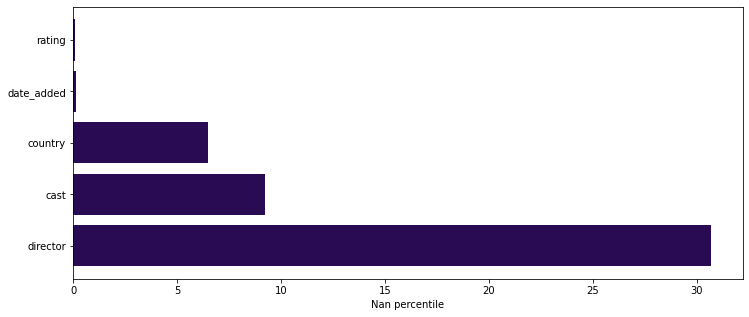

In [105]:
#Visualizing missing percentile
plt.figure(figsize=(12,5))
sns.set_palette("inferno")
plt.barh(nan_per["columns_with_nan"], nan_per["nan_percentile"])
plt.xlabel("Nan percentile")

In [17]:
df['country'].mode()[0]

'United States'

<Figure size 1080x432 with 0 Axes>

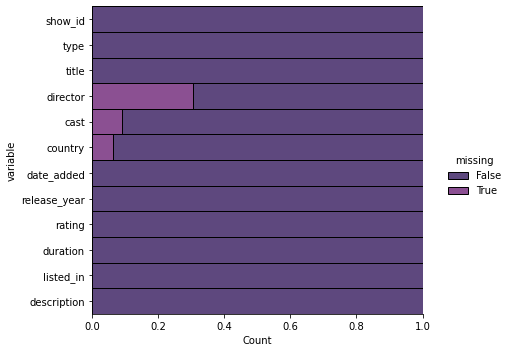

In [113]:
#Visualizing missing and non missing values in our dataframe

plt.figure(figsize=(15,6))
sns.displot(data=df.isna().melt(value_name="missing"), y="variable",hue="missing",multiple="fill", aspect=1.25)

In [125]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Handling NULL values

In [136]:
df[df["country"].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
16,s17,TV Show,Feb-09,NaN,"Shahd El Yaseen, Shaila Sabt, Hala, Hanadi Al-...",NaN,"March 20, 2019",2018,TV-14,1 Season,"International TV Shows, TV Dramas","As a psychology professor faces Alzheimer's, h..."
38,s39,TV Show,แผนร้ายนายเจ้าเล่ห์,NaN,"Chutavuth Pattarakampol, Sheranut Yusananda, N...",NaN,"March 30, 2019",2016,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...","When two brothers fall for two sisters, they q..."
67,s68,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
97,s98,Movie,3 Deewarein,Nagesh Kukunoor,"Naseeruddin Shah, Jackie Shroff, Juhi Chawla, ...",NaN,"December 31, 2019",2003,TV-MA,121 min,"Dramas, International Movies, Thrillers",A reporter interviews three convicts on death ...
117,s118,Movie,5 Cowok Jagoan,Anggy Umbara,"Ario Bayu, Arifin Putra, Dwi Sasono, Muhadkly ...",NaN,"January 5, 2019",2017,TV-MA,106 min,"Action & Adventure, Comedies, International Mo...",Yanto asks his friends to help save a girlfrie...
141,s142,TV Show,7SEEDS,NaN,"Nao Toyama, Jun Fukuyama, Katsuyuki Konishi, Y...",NaN,"March 26, 2020",2020,TV-MA,2 Seasons,"Anime Series, International TV Shows",Shy Natsu awakens as part of a group chosen to...
178,s179,Movie,A Go! Go! Cory Carson Halloween,"Alex Woo, Stanley Moore","Alan C. Lim, Smith Foreman, Maisie Benson, Ann...",NaN,"October 2, 2020",2020,TV-Y,22 min,Children & Family Movies,"Cory, Chrissy and Freddie are on the hunt for ..."
179,s180,Movie,A Go! Go! Cory Carson Summer Camp,"Stanley Moore, Alex Woo","Alan C. Lim, Smith Foreman, Abigail Vibat, Pfi...",NaN,"August 4, 2020",2020,TV-Y,21 min,Children & Family Movies,Cory's spending the summer at Camp Friendship ...
204,s205,Movie,A Mission in an Old Movie,Ahmad El-Badri,"Edward, Fifi Abdo, Lotfy Labib, Madeleine Mata...",NaN,"April 25, 2019",2012,TV-MA,98 min,"Comedies, International Movies",A young man struggles with his overbearing mot...
242,s243,Movie,A Trash Truck Christmas,Eddie Rosas,"Henry Keane, Glen Keane, Lucas Neff, Brian Bau...",NaN,"December 11, 2020",2020,TV-Y,28 min,Children & Family Movies,When Santa crash-lands in the junkyard on Chri...


After going through titles and cast names in our df of country NaN value, i figured out few rows which contained indian movies and tv shows, so lets assign those rows with our country name. Below are the rows which were inspected to be Indian movies or tv_shows

In [142]:
indian_mov_rows = [509,525,548,657,658,659,661,662,889,1124,1318,1319,1320,1321,3444,3445,3446,3447,3449,3450,3451,3454,3470,3668,3669,3670,3671,3672,3673,3674,
4043,4341,4441,4594,4595,4839,5035,5036,5049,5395,5396,5402,6040]

In [168]:
df[df["director"].isna()].shape

(0, 12)

In [152]:
for index_num in indian_mov_rows:
  df.loc[index_num,"country"] = "India"


In [234]:
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'] = df['cast'].fillna("No Data", inplace=True)
df['director'] = df['director'].fillna("No Data", inplace=True)

In [190]:
df[df["rating"].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


Since ther are only 7 rows so lets just browse the rating from internet and replace them

In [188]:
rating_replacements = {67:"TV-PG",2359:"TV-14",3660:"TV-MA",3736:"TV-MA",3737:"NR",3738:"TV-MA",4323:"TV-MA"}
for ind, rate in rating_replacements.items():
  df.loc[ind, "rating"] = rate

In [189]:
df.isna().sum()

show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      10
release_year     0
rating           0
duration         0
listed_in        0
description      0
dtype: int64

Since its hard to find date_added through internet, lets just drop them (10rows)

In [194]:
df = df[~df["date_added"].isna()]

In [235]:
df.shape

(7777, 14)

### Feature Manipulation

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 7786
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       7777 non-null   object        
 1   type          7777 non-null   object        
 2   title         7777 non-null   object        
 3   director      7777 non-null   object        
 4   cast          7777 non-null   object        
 5   country       7777 non-null   object        
 6   date_added    7777 non-null   datetime64[ns]
 7   release_year  7777 non-null   int64         
 8   rating        7777 non-null   object        
 9   duration      7777 non-null   object        
 10  listed_in     7777 non-null   object        
 11  description   7777 non-null   object        
 12  month         7777 non-null   object        
 13  year_added    7777 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(11)
memory usage: 911.4+ KB


In [200]:
df["date_added"] = pd.to_datetime(df['date_added'])
df["month"] = df["date_added"].dt.month_name()
df["year_added"] = df["date_added"].dt.year

In [236]:
filtered_countries = df["country"].str.split(", ")
filtered_countries = filtered_countries.explode("country")

In [246]:
filtered_countries.value_counts()[0:10].to_frame(name= "Counts")

,Counts
United States,3753
India,1033
United Kingdom,721
Canada,412
France,349
Japan,286
Spain,215
South Korea,212
Germany,199
Mexico,154


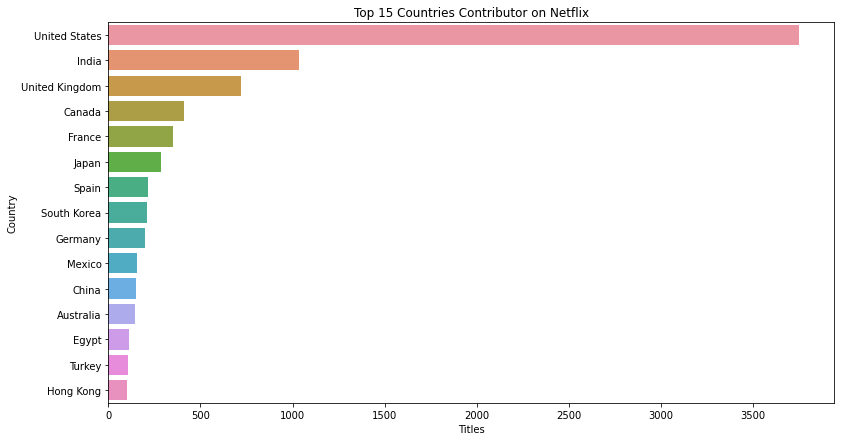

In [247]:
plt.figure(figsize=(13,7))
g = sns.countplot(y = filtered_countries, order=filtered_countries.value_counts().index[:15])
plt.title('Top 15 Countries Contributor on Netflix')
plt.xlabel('Titles')
plt.ylabel('Country')
plt.show()

In [214]:
df.country.dtype

dtype('O')

In [202]:
df.head(20)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month,year_added
0,s1,TV Show,3%,No Data,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,August,2020
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,December,2016
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",December,2018
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",November,2017
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,January,2020
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,2017-07-01,2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,July,2017
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,2020-06-01,2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",June,2020
7,s8,Movie,187,Kevin Reynolds,"Samuel L. Jackson, John Heard, Kelly Rowan, Cl...",United States,2019-11-01,1997,R,119 min,Dramas,After one of his high school students attacks ...,November,2019
8,s9,Movie,706,Shravan Kumar,"Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...",India,2019-04-01,2019,TV-14,118 min,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w...",April,2019
9,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,2017-12-15,2008,TV-MA,143 min,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...,December,2017
